<h1><span style="background-color:blue; color:white; padding: 5px;">Entrainment de modèles avec RandomForest Regressor<br></h1>
</h4><span style="background-color:red; color:white; padding: 5px;">Utiliser un outil permettant de rafraîchir la page régulièrement pour éviter la mise en sommeil de MLflow sur Heroku
</span></h4>

In [1]:
import pandas as pd
from functions2 import *

2024-02-14 15:24:40.436070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-14 15:24:40.521027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-14 15:24:40.522800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 15:24:42.075914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement sur toutes les ventes, un seul modèle.</span></h2>

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Les données s'étendent du 2018-07-01 00:00:00 au 2018-12-31 00:00:00
Il y a 100000 ventes sur cette durée.
Split des données en cours...
Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   7.1s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   6.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   6.8s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   6.1s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   5.9s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_mae,split1_test_mae,...,std_test_mae,rank_test_mae,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,6.370792,0.443395,0.079311,0.009003,10,2,50,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",-66198.516202,-64571.580974,...,1276.962691,1,0.465956,0.448704,0.467675,0.409618,0.355355,0.429462,0.042539,1


Ré-entraînement avec les meilleurs hyperparamètres en cours...
Entraînement OK
Tracé du graphique en cours...
Itération N°1 : train score = 0.7504340512965142 -- validation score = 0.33616564166762464
Itération N°2 : train score = 0.7276320871577255 -- validation score = 0.3726631837394111
Itération N°3 : train score = 0.7017731563367183 -- validation score = 0.387673187971009
Itération N°4 : train score = 0.674622362042959 -- validation score = 0.418948961034035
Itération N°5 : train score = 0.6697695583429631 -- validation score = 0.42045774619321974
Itération N°6 : train score = 0.6567557857156707 -- validation score = 0.4217430598026398
Itération N°7 : train score = 0.6431098498557828 -- validation score = 0.44583416985655333
Itération N°8 : train score = 0.6309068170338048 -- validation score = 0.419706360470982
Itération N°9 : train score = 0.619763772406757 -- validation score = 0.374386195226738
Itération N°10 : train score = 0.6173505483661768 -- validation score = 0.446813618

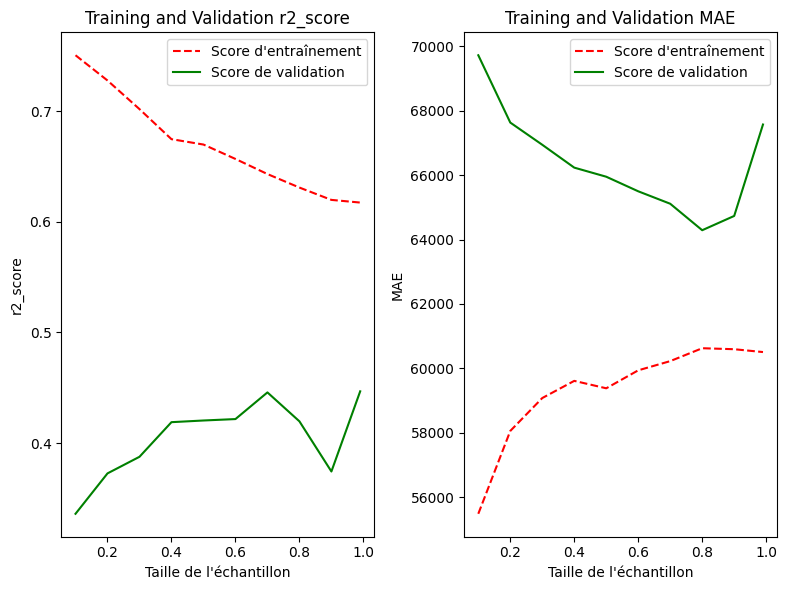

In [2]:
# Chargement des données
query=f"""
SELECT 
    V.SURFACE_BATI,
    V.DEPENDANCES,
    V.ID_COMMUNE,
    R.Name_region,
    V.SURFACE_TERRAIN,
    V.DATE_MUTATION,
    V.MONTANT
FROM VENTES V
INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
WHERE V.MONTANT>15000
AND V.MONTANT<6500000
AND V.SURFACE_BATI>0
AND V.NB_PIECES>0
# AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
"""

df = loading_data(query)
print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
print(f"Il y a {df.shape[0]} ventes sur cette durée.")

# Split des données
X_train,y_train, X_test, y_test = split(df)

# Labellisation et standardisation
X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

# Entraînement du modèle
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2]
}   
cv=5
model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)


# Sauvegarde avec MLflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "test"
run_name = "only_one_model"
model_name = f"RFR_all_datas_only_one_model"

# Affichage et enregistrement de la learning curve
image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)

# log_mlflow(uri_tracking,
#         experiment_name, run_name,
#         best_params,
#         model, model_name,
#         X_test, y_test,
#         encoders,scalers,
#         image_path)

<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement sur toutes les ventes. Un modèle pour les appartements et un modèle pour les maisons</span></h2>

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Les données s'étendent du 2018-07-01 00:00:00 au 2022-12-31 00:00:00
Il y a 1666058 ventes sur cette durée.
Split des données en cours...
Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.9min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.9min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.9min
Ré-entraînement avec les meilleurs hyperparamètres en cours...
Entraînement OK
Tracé du graphique en cours...
Itération N°1 : train score = 0.5822497965369082 -- validation score = 0.4603723065131744
Itéra

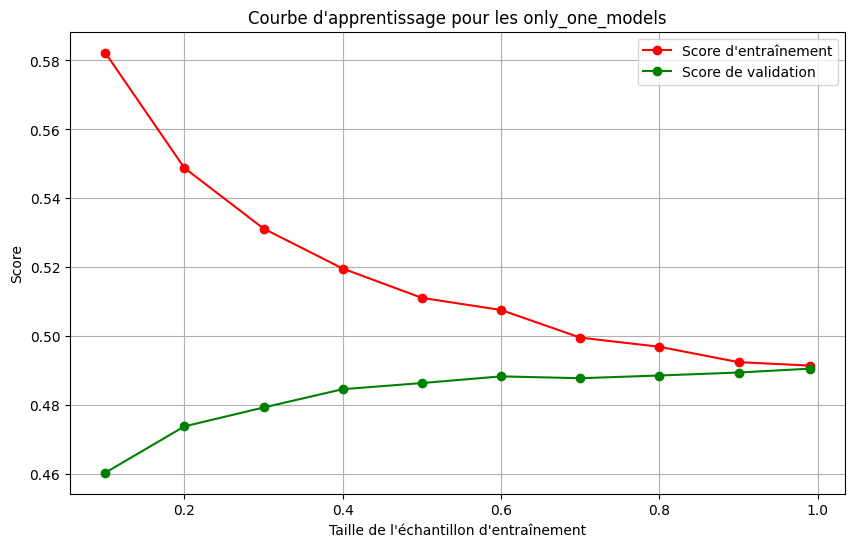

Tracé OK
Log du modèle et des artifacts en cours...


Successfully registered model 'RFR_all_datas_only_one_model'.
2024/02/14 10:28:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFR_all_datas_only_one_model, version 1
Created version '1' of model 'RFR_all_datas_only_one_model'.


Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Les données s'étendent du 2018-07-01 00:00:00 au 2022-12-31 00:00:00
Il y a 2452729 ventes sur cette durée.
Split des données en cours...
Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 4.4min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 4.4min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 4.1min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 4.1min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 4.3min


2024/02/14 10:56:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Ré-entraînement avec les meilleurs hyperparamètres en cours...


2024/02/14 11:01:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Entraînement OK
Tracé du graphique en cours...


2024/02/14 11:02:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°1 : train score = 0.5899508125493196 -- validation score = 0.4896495580717001


2024/02/14 11:03:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°2 : train score = 0.5597572110791653 -- validation score = 0.5020978484546053


2024/02/14 11:05:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°3 : train score = 0.5466471469542975 -- validation score = 0.5118962828512921


2024/02/14 11:07:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°4 : train score = 0.5356365999836221 -- validation score = 0.5143689411350503


2024/02/14 11:10:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°5 : train score = 0.53563939438556 -- validation score = 0.518404910333411


2024/02/14 11:14:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°6 : train score = 0.5341267671146988 -- validation score = 0.5224979814684738


2024/02/14 11:18:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°7 : train score = 0.5293631849179752 -- validation score = 0.5227152675507938


2024/02/14 11:22:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°8 : train score = 0.5259061786514163 -- validation score = 0.5231458191242249


2024/02/14 11:27:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°9 : train score = 0.5274969631390297 -- validation score = 0.5254931453481286


2024/02/14 11:34:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°10 : train score = 0.5258615073360673 -- validation score = 0.5260007489136023


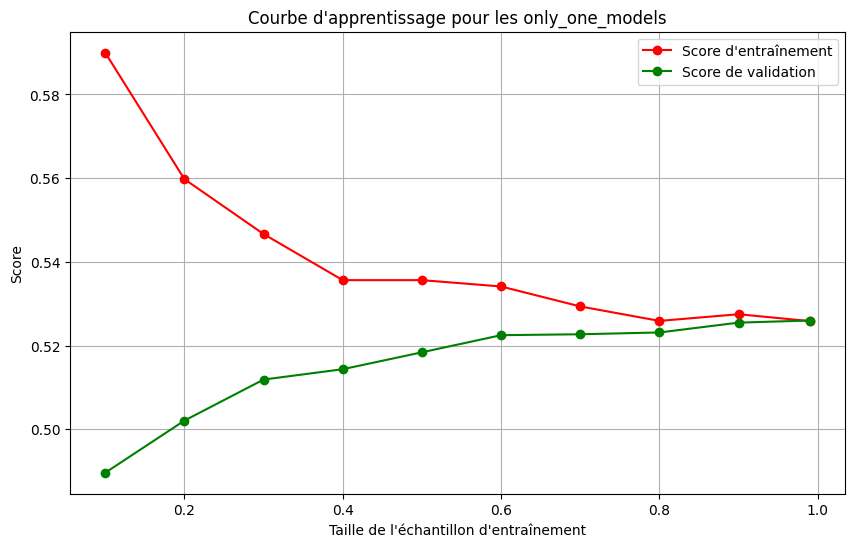

Tracé OK
Log du modèle et des artifacts en cours...


Registered model 'RFR_all_datas_only_one_model' already exists. Creating a new version of this model...
2024/02/14 11:34:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFR_all_datas_only_one_model, version 2
Created version '2' of model 'RFR_all_datas_only_one_model'.


In [5]:
for type_de_bien in ["Appartement","Maison"]:
    # Chargement des données
    query=f"""
    SELECT 
        V.SURFACE_BATI,
        V.DEPENDANCES,
        V.ID_COMMUNE,
        R.Name_region,
        {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
        V.DATE_MUTATION,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE V.MONTANT>15000
    AND V.MONTANT<6500000
    AND T.NAME_TYPE_BIEN='{type_de_bien}'
    AND V.SURFACE_BATI>0
    AND V.NB_PIECES>0
    # AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
    """

    df = loading_data(query)
    print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
    print(f"Il y a {df.shape[0]} ventes sur cette durée.")

    # Split des données
    X_train,y_train, X_test, y_test = split(df)

    # Labellisation et standardisation
    X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

    # Entraînement du modèle
    param_grid = {
        'n_estimators': [50],
        'max_depth': [10],
        'min_samples_split': [2]
    }   
    cv=5
    model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)


    # Sauvegarde avec MLflow
    uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
    experiment_name = "RandomForestRegressor_all_datas_region_time"
    run_name = "only_one_model"
    model_name = f"RFR_all_datas_only_one_model"

    # Affichage et enregistrement de la learning curve
    image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)

    log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement sur 12 mois et test sur les 3derniers mois</span></h2>

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Les données s'étendent du 2021-09-30 00:00:00 au 2022-12-31 00:00:00
Il y a 711111 ventes sur cette durée.
Voici un aperçue des données :
Split des données en cours...
Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.9min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 4.3min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time= 3.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 6.2min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 6.0min
[CV

2024/02/13 16:01:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Ré-entraînement avec les meilleurs hyperparamètres en cours...


2024/02/13 16:08:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Entraînement OK
Tracé du graphique en cours...


2024/02/13 16:09:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°1 : train score = 0.878423981779919 -- validation score = 0.534494314077161


2024/02/13 16:11:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°2 : train score = 0.8839642189195666 -- validation score = 0.6026015929432618


2024/02/13 16:14:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°3 : train score = 0.8856733058532766 -- validation score = 0.6470862183594086


2024/02/13 16:17:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°4 : train score = 0.8888514396428573 -- validation score = 0.6956645595529848


2024/02/13 16:21:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°5 : train score = 0.8934450884424789 -- validation score = 0.7339583309226024


2024/02/13 16:26:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°6 : train score = 0.8928641731809693 -- validation score = 0.7704354347576545


2024/02/13 16:31:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°7 : train score = 0.8951451950358567 -- validation score = 0.8051315172740954


2024/02/13 16:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°8 : train score = 0.8961255221163391 -- validation score = 0.8350425723194465


2024/02/13 16:49:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°9 : train score = 0.8976186688638637 -- validation score = 0.8664920340139676


2024/02/13 16:58:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°10 : train score = 0.898351999314661 -- validation score = 0.8952542440119237


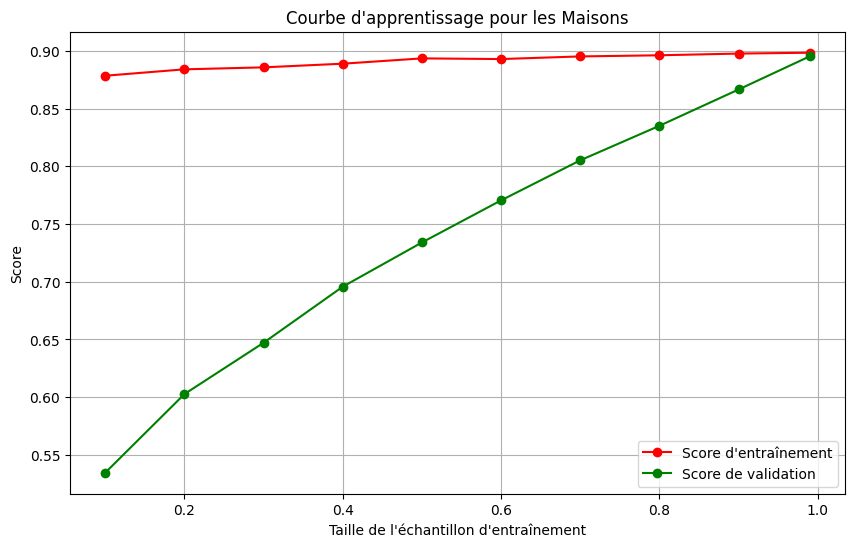

Tracé OK
Log du modèle et des artifacts en cours...


MlflowException: API request to https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/api/2.0/mlflow-artifacts/artifacts/6/a2df7dd220044f1a904445f0c63f69fa/artifacts/ImmoApp/model.pkl failed with exception HTTPSConnectionPool(host='mlflowimmoappkevleg-737621d410d0.herokuapp.com', port=443): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/6/a2df7dd220044f1a904445f0c63f69fa/artifacts/ImmoApp/model.pkl (Caused by ResponseError('too many 503 error responses'))

In [13]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
    }   
cv=5

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_15months_all_datas_region"

for type_de_bien in ["Appartement","Maison"] :

    run_name = type_de_bien
    model_name = f"RFR_all_datas_{type_de_bien}"
    
    query=f"""
    SELECT 
        V.SURFACE_BATI,
        V.DEPENDANCES,
        V.ID_COMMUNE,
        R.Name_region,
        {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
        V.DATE_MUTATION,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE V.MONTANT>15000  AND V.MONTANT<6500000
    AND T.NAME_TYPE_BIEN='{type_de_bien}'
    AND V.SURFACE_BATI>0
    AND V.NB_PIECES>0
    AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
    """

    df = loading_data(query)
    print(f"Les données s'étendent du {df['DATE_MUTATION'].min()} au {df['DATE_MUTATION'].max()}")
    print(f"Il y a {df.shape[0]} ventes sur cette durée.")
    print("Voici un aperçue des données :")
    
    X_train,y_train, X_test, y_test = split(df)

    X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

    model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

    # Tracé et enregistrement de la learning curve
    image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)
    
    log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

<h2><span style="background-color:grey; color:white; padding: 5px;">Un modèle par type de bien en prenant comme paramètre la surface, le prix au m², dépendances et la surface du terrain s'il s'agit d'une maison</span></h2>

In [2]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
    }   
cv=5

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_m2_all"

# for type_de_bien in ["Maison","Appartement"] :
for type_de_bien in ["Appartement","Maison"] :
    run_name = type_de_bien
    model_name = f"RFR_all_datas_{type_de_bien}"

    query=f"""
    SELECT 
        V.SURFACE_BATI,
        V.DEPENDANCES,
        V.ID_COMMUNE,
        R.Name_region,
        {'V.SURFACE_TERRAIN,' if type_de_bien=="Maison" else ''}
        V.DATE_MUTATION,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE V.MONTANT>15000  AND V.MONTANT<6500000
    AND T.NAME_TYPE_BIEN='{type_de_bien}'
    AND V.SURFACE_BATI>0
    AND V.NB_PIECES>0
    AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
    """

    df = loading_data(query)
        
    X_train,y_train, X_test, y_test = split_with_m2(df)

    X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

    model, best_params = train_model_randomforest(X_train,y_train, param_grid, cv)

    # Tracé et enregistrement de la learning curve
    image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)
    
    log_mlflow(uri_tracking,
           experiment_name, run_name,
            best_params,
            model, model_name,
            X_test, y_test,
            encoders,scalers,
            image_path)

   

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Split des données en cours...


/home/kevin/workspace/PCO/certif_app_immo/model/functions2.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['M2'] = df_train['MONTANT'] / df_train['SURFACE_BATI']


Split OK


<h2><span style="background-color:grey; color:white; padding: 5px;">Un seul modèle sur la plage des dates des 15 derniers moise et en prenant comme paramètre la surface, le prix au m², dépendances et la surface du terrain</span></h2>

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Split des données en cours...


/home/kevin/workspace/PCO/certif_app_immo/model/functions2.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['M2'] = df_train['MONTANT'] / df_train['SURFACE_BATI']


Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.8min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.4min
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time= 1.5min


2024/02/14 17:38:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_mae,split1_test_mae,...,std_test_mae,rank_test_mae,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,98.866289,10.696974,0.967922,0.275316,10,2,50,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",-74229.583833,-65145.65944,...,5922.008053,1,0.617798,0.687664,0.728485,0.683702,0.604397,0.664409,0.04646,1


Ré-entraînement avec les meilleurs hyperparamètres en cours...


2024/02/14 17:39:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


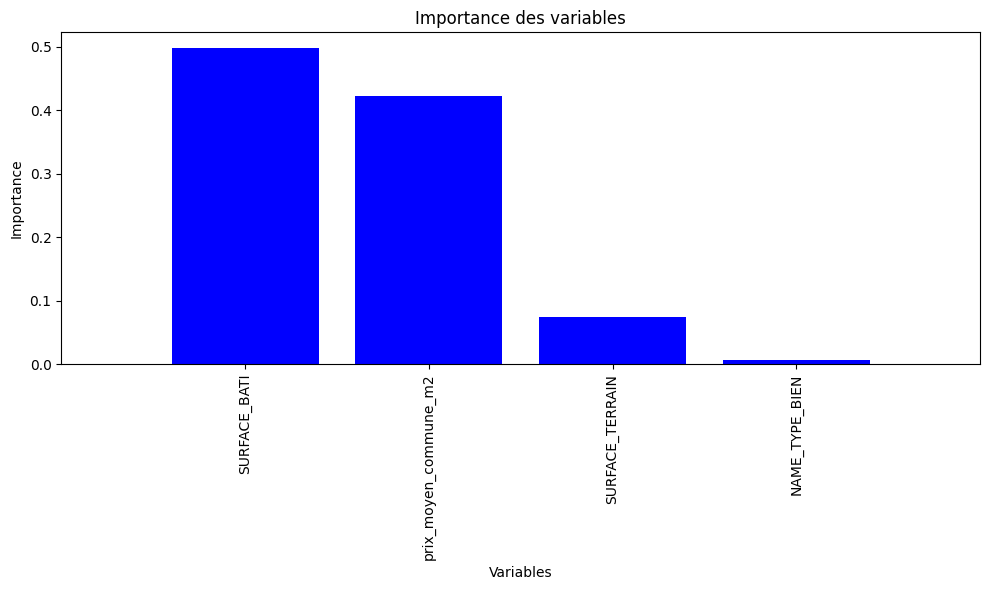

Entraînement OK
Tracé du graphique en cours...


2024/02/14 17:39:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°1 : train score = 0.8115643231067093 -- validation score = 0.6811680989278599


2024/02/14 17:40:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°2 : train score = 0.79348602919398 -- validation score = 0.6850388683254163


2024/02/14 17:40:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°3 : train score = 0.7783562633141068 -- validation score = 0.6926893080470116


2024/02/14 17:41:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°4 : train score = 0.7722125774259407 -- validation score = 0.6949554113881415


2024/02/14 17:42:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°5 : train score = 0.7644857861538102 -- validation score = 0.694110370597149


2024/02/14 17:43:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°6 : train score = 0.7585359576461779 -- validation score = 0.6969604747029654


2024/02/14 17:44:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°7 : train score = 0.7505661383811878 -- validation score = 0.6981173362996009


2024/02/14 17:46:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°8 : train score = 0.7476500626485033 -- validation score = 0.7007897644132024


2024/02/14 17:48:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°9 : train score = 0.7424078523837379 -- validation score = 0.6991211073261847


2024/02/14 17:50:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INVALID_PARAMETER_VALUE: The experiment 0 must be in the 'active' state. Current state is deleted.


Itération N°10 : train score = 0.7405041173046865 -- validation score = 0.7016688378934455


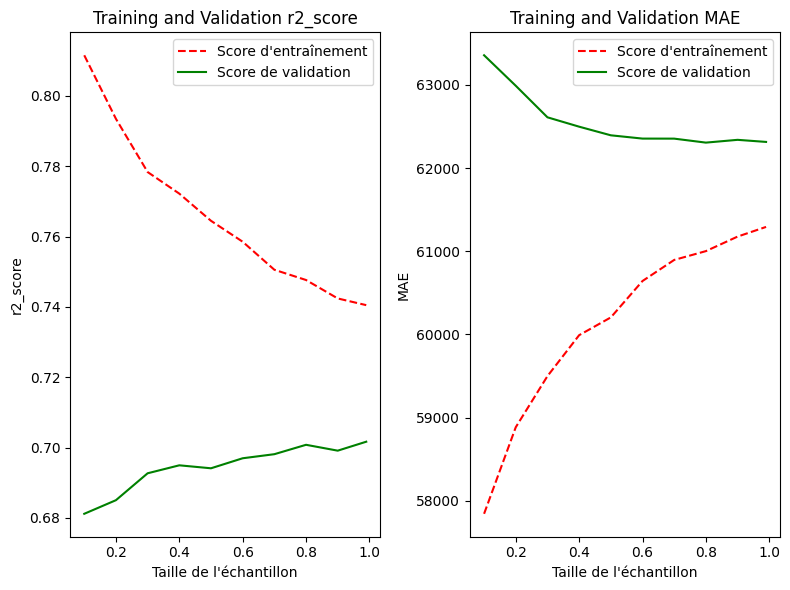

Log du modèle et des artifacts en cours...


Registered model 'RFR_all_datas_with_m2' already exists. Creating a new version of this model...
2024/02/14 17:50:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFR_all_datas_with_m2, version 10
Created version '10' of model 'RFR_all_datas_with_m2'.


In [9]:
# Configuration du modèle
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2]
    }   
cv=5

# Configuration de mlflow
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "RandomForestRegressor_m2_all"
run_name = "15months_type_bien_surface_bati_terrain_m2"
model_name = f"RFR_all_datas_with_m2"

query=f"""
SELECT 
    V.SURFACE_BATI,
    V.ID_COMMUNE,
    V.SURFACE_TERRAIN,
    T.NAME_TYPE_BIEN,
    V.DATE_MUTATION,
    V.MONTANT
FROM VENTES V
INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
WHERE V.MONTANT>15000  AND V.MONTANT<6500000
AND V.SURFACE_BATI>0
AND V.NB_PIECES>0
AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
AND R.Name_region NOT IN("Martinique", "Guyane", "La Réunion", "Mayotte", "Guadeloupe");
"""

df = loading_data(query)
    
X_train,y_train, X_test, y_test = split_with_m2(df)

X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

model, best_params, image_path_features_importances = train_model_randomforest(X_train,y_train, param_grid, cv)

# Tracé et enregistrement de la learning curve
image_path = plot_learning_curve(RandomForestRegressor(**best_params), run_name, X_train, y_train)

log_mlflow(uri_tracking,
        experiment_name, run_name,
        best_params,
        model, model_name,
        X_test, y_test,
        encoders,scalers,
        image_path, image_path_features_importances)